# Tuning a `multi_match` `best_fields` query

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, evaluate_mrr100_dev_templated, optimize_query_mrr100, optimize_query_mrr100_templated
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://34.77.83.193:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

index = 'msmarco-document.doc2query'
template_id = 'query'

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

## Experiments

### Base fields + bigrams

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2677
CPU times: user 2.28 s, sys: 1.08 s, total: 3.36 s
Wall time: 13min 25s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:04 (remains: 0:52:24)
   | 0.1885 (best: 0.1885) - {'tie_breaker': 0.4183630985342458, 'url|boost': 7.055914550656581, 'title|boost': 8.435374446315553, 'title_bigrams|boost': 9.549699993339155, 'body|boost': 0.4067751386540153, 'body_bigrams|boost': 2.259944079169824}
 > iteration 2/50, took 0:01:12 (remains: 0:57:41)
   | 0.2697 (best: 0.2697) - {'tie_breaker': 0.2794493107416936, 'url|boost': 5.712457051840789, 'title|boost': 3.6033115252009558, 'title_bigrams|boost': 7.349883439851414, 'body|boost': 8.706339586179087, 'body_bigrams|boost': 3.3033242685284985}
 > iteration 3/50, took 0:01:11 (remains: 0:55:58)
   | 0.2652 (best: 0.2697) - {'tie_breaker': 0.6051708066385135, 'url|boost': 0.8017589657014791, 'title|boost': 7.04394604378

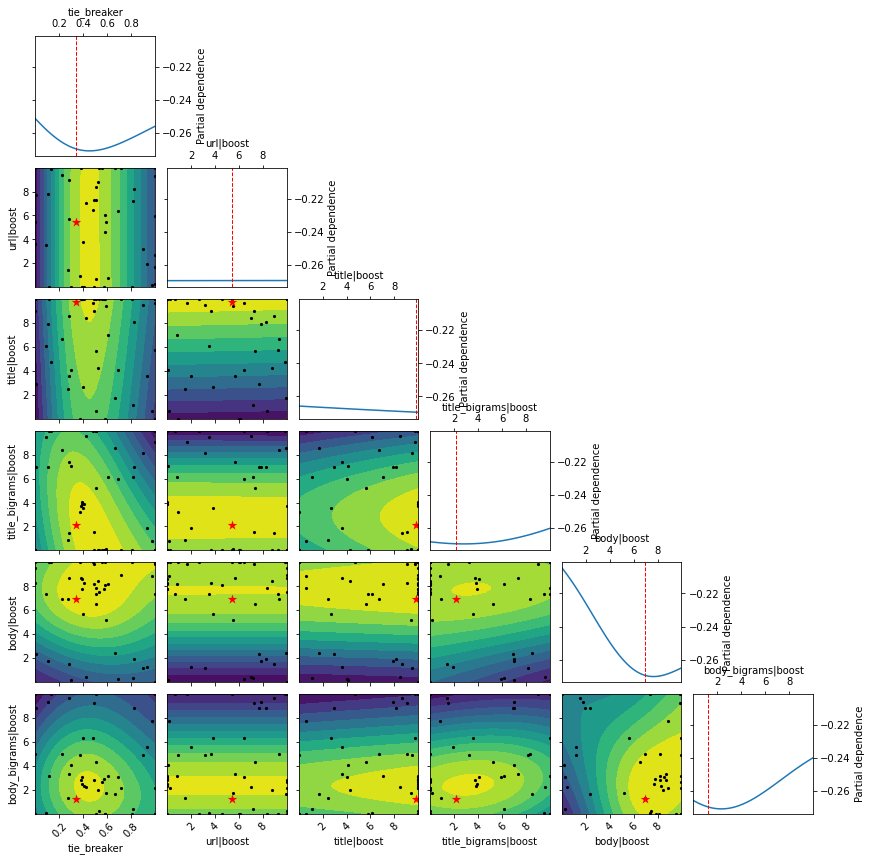

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3040
CPU times: user 2.23 s, sys: 766 ms, total: 3 s
Wall time: 5min 34s


In [10]:
final_params

{'tie_breaker': 0.3418537880788745,
 'url|boost': 5.439886689028702,
 'title|boost': 9.80587347149196,
 'title_bigrams|boost': 2.1185632877763,
 'body|boost': 6.948726509442214,
 'body_bigrams|boost': 1.2274853496022289}

### Base fields + expansions

In [11]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
    ]
}

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3236
CPU times: user 2.24 s, sys: 777 ms, total: 3.01 s
Wall time: 2min 59s


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:35 (remains: 0:29:08)
   | 0.3093 (best: 0.3093) - {'tie_breaker': 0.06649518702844949, 'url|boost': 0.7767351648706134, 'title|boost': 1.652764918769324, 'body|boost': 3.5797646598780424, 'expansions|boost': 2.64850593668918}
 > iteration 2/50, took 0:00:34 (remains: 0:27:34)
   | 0.3017 (best: 0.3093) - {'tie_breaker': 0.8414445067316323, 'url|boost': 6.762273120471807, 'title|boost': 8.455044250763532, 'body|boost': 6.058009825491465, 'expansions|boost': 7.739327681197178}
 > iteration 3/50, took 0:00:33 (remains: 0:25:58)
   | 0.2970 (best: 0.3093) - {'tie_breaker': 0.9578777012579748, 'url|boost': 2.806858975625019, 'title|boost': 6.973558810847332, 'body|boost': 9.439050520254511, 'expansions|boost': 3.2599221835767715}
 >

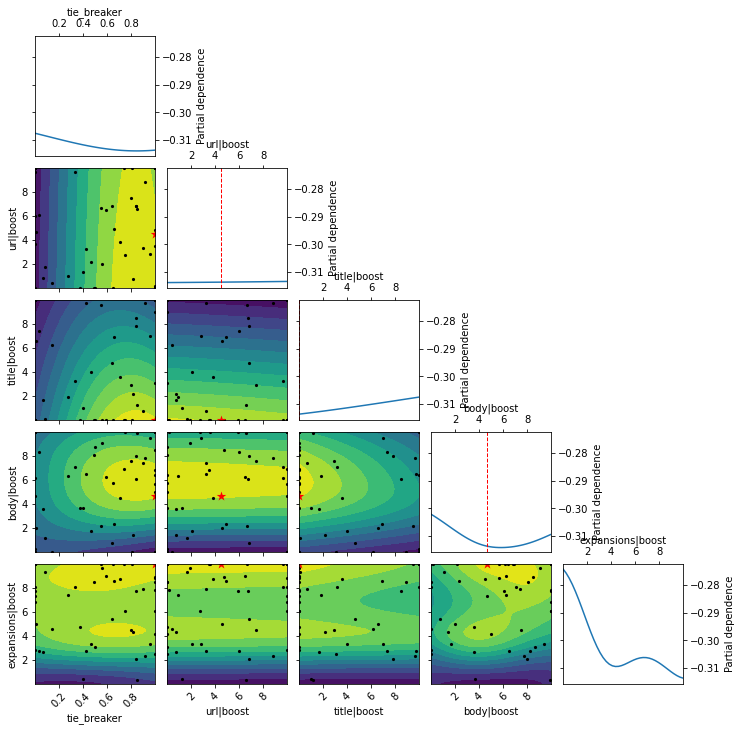

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3342
CPU times: user 2.04 s, sys: 708 ms, total: 2.75 s
Wall time: 2min 39s


In [16]:
final_params

{'tie_breaker': 1.0,
 'url|boost': 4.490308442482419,
 'title|boost': 0.0,
 'body|boost': 4.647128754102814,
 'expansions|boost': 10.0}

### Base fields + expansions + bigrams

In [17]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3204
CPU times: user 2.39 s, sys: 912 ms, total: 3.3 s
Wall time: 7min 4s


In [23]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:24 (remains: 1:09:18)
   | 0.2659 (best: 0.2659) - {'tie_breaker': 0.2932623522034136, 'url|boost': 2.599058545644874, 'title|boost': 3.0278783774916533, 'title_bigrams|boost': 6.945154280446047, 'body|boost': 1.477280000045689, 'body_bigrams|boost': 8.969294723668712, 'expansions|boost': 3.930212688617727, 'expansions_bigrams|boost': 3.773131652506072}
 > iteration 2/50, took 0:01:23 (remains: 1:07:09)
   | 0.2889 (best: 0.2889) - {'tie_breaker': 0.8597343330620504, 'url|boost': 8.713303277160929, 'title|boost': 5.449542888084725, 'title_bigrams|boost': 8.663677167627093, 'body|boost': 7.331062448848458, 'body_bigrams|boost': 3.2914120047071664, 'expansions|boost': 5.2040498266379505, 'expansions_bigrams|boost': 9.322298756684946}
 > iteration 3/50, took 0:01:24 (remains: 1:06:19)
   | 0.2848 (best

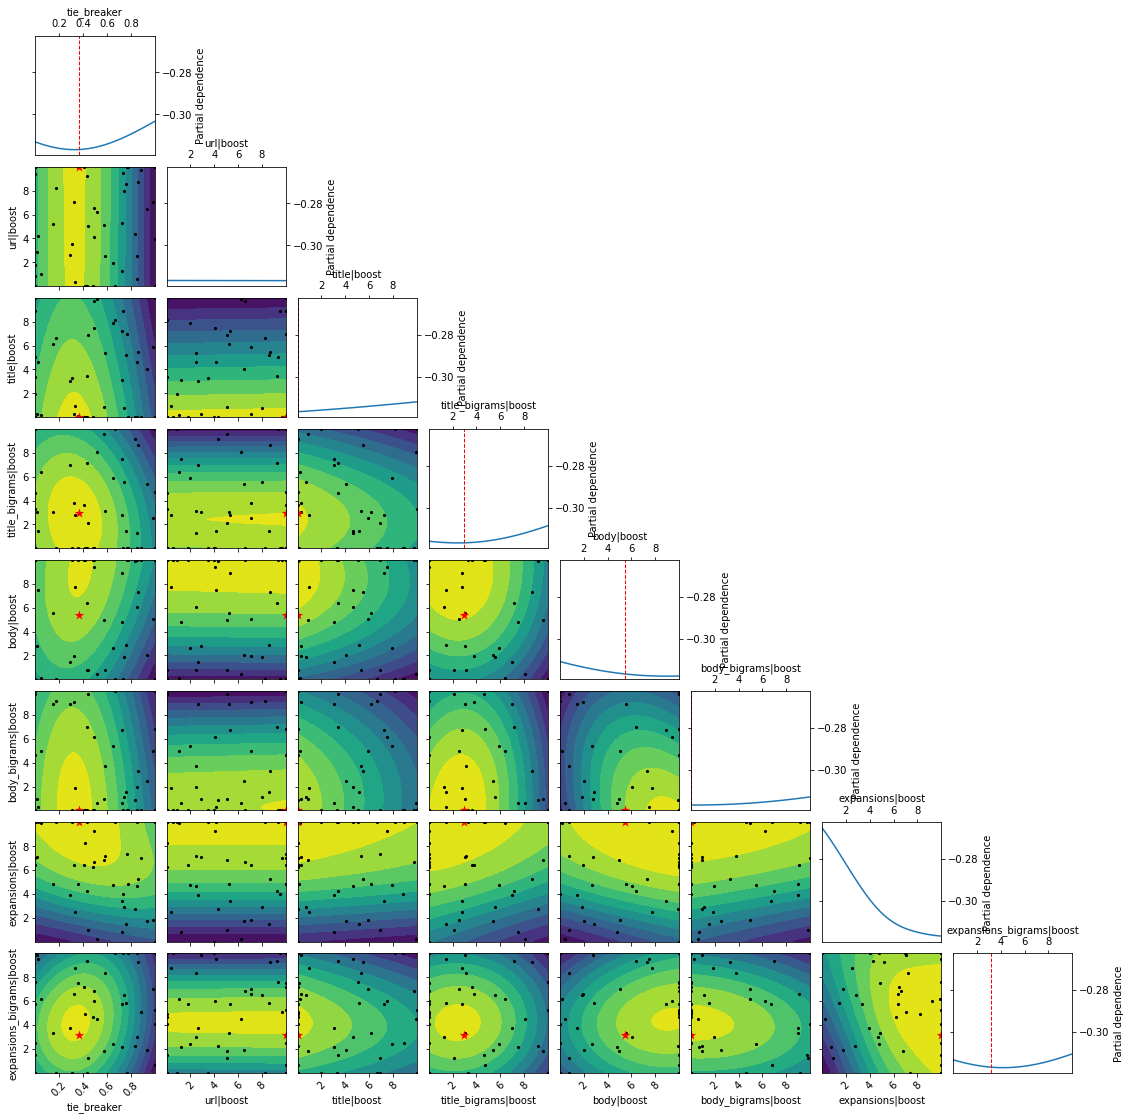

In [24]:
_ = plot_objective(metadata, sample_source='result')

In [25]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3375
CPU times: user 2.09 s, sys: 962 ms, total: 3.06 s
Wall time: 7min 14s


In [26]:
final_params

{'tie_breaker': 0.3617689052120982,
 'url|boost': 10.0,
 'title|boost': 0.0,
 'title_bigrams|boost': 2.9553505552625428,
 'body|boost': 5.439794134513196,
 'body_bigrams|boost': 0.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 3.191071351836343}

### Selective fields

Based on the results from above, remove fields with `0` boost values.

In [27]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [28]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3227
CPU times: user 2.48 s, sys: 971 ms, total: 3.45 s
Wall time: 4min 12s


In [29]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:50 (remains: 0:41:32)
   | 0.3116 (best: 0.3116) - {'tie_breaker': 0.47073383550086934, 'url|boost': 2.2301180243027723, 'title_bigrams|boost': 0.3523642925008686, 'body|boost': 6.989519484073822, 'expansions|boost': 6.636597432179717, 'expansions_bigrams|boost': 8.826231185418129}
 > iteration 2/50, took 0:00:41 (remains: 0:32:49)
   | 0.3145 (best: 0.3145) - {'tie_breaker': 0.21094547792686696, 'url|boost': 8.087492032035437, 'title_bigrams|boost': 4.823706203584743, 'body|boost': 6.654878594571791, 'expansions|boost': 9.168327028834756, 'expansions_bigrams|boost': 7.107328655906393}
 > iteration 3/50, took 0:00:39 (remains: 0:31:18)
   | 0.2807 (best: 0.3145) - {'tie_breaker': 0.7620186975938212, 'url|boost': 8.27462978780815, 'title_bigrams|boost': 7.081333302642781, 'body|boost': 8.121209405092

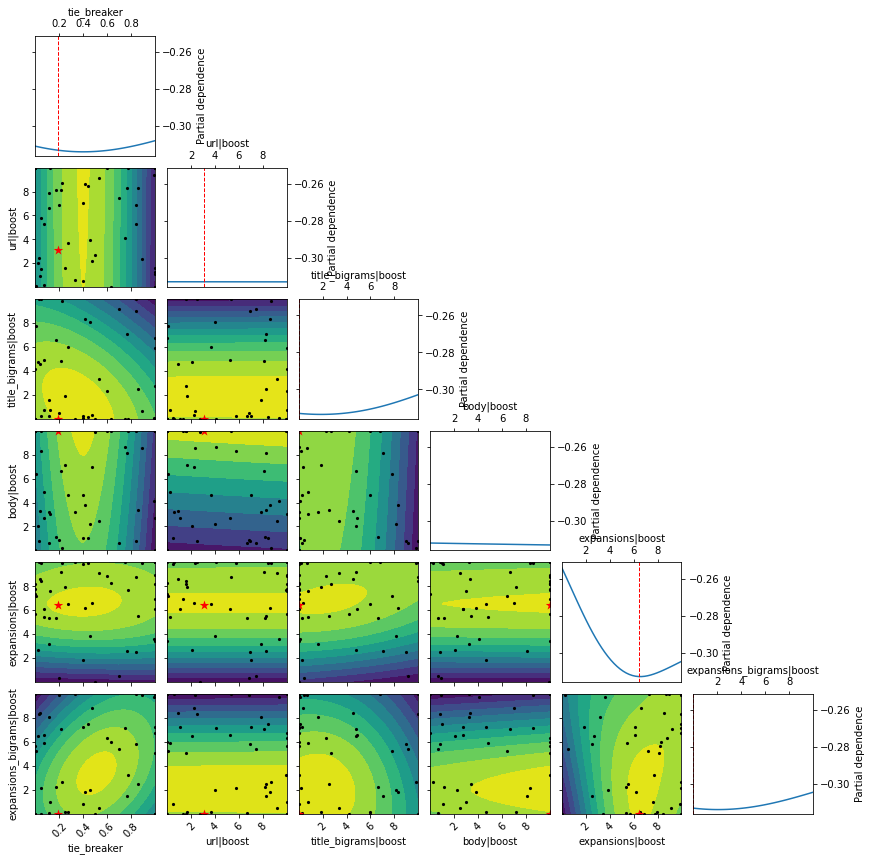

In [30]:
_ = plot_objective(metadata, sample_source='result')

In [31]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3359
CPU times: user 2.2 s, sys: 579 ms, total: 2.78 s
Wall time: 3min 53s


In [32]:
final_params

{'tie_breaker': 0.18625523276047445,
 'url|boost': 3.1281756590972924,
 'title_bigrams|boost': 0.0,
 'body|boost': 10.0,
 'expansions|boost': 6.436467657038456,
 'expansions_bigrams|boost': 0.0}

## Archived experiments

In [18]:
%%time

## from random search
_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params={
    'tie_breaker': 0.4549730682206822,
    'url|boost': 0.34728407296025626,
    'title|boost': 8.21907753421881,
    'body|boost': 4.7837874442927735,
    'body_expansion|boost': 8.136976669448675,
    'body+expansion|boost': 8.391765667142831,
})

Evaluation with: MRR@100
Score: 0.3400
CPU times: user 2.33 s, sys: 514 ms, total: 2.84 s
Wall time: 11min 36s


In [30]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params={
    'tie_breaker': 0.455,
    'url|boost': 0.35,
    'title|boost': 8.2,
    'body|boost': 5.0,
    'body_expansion|boost': 8.0,
    'body+expansion|boost': 20.0,
})

Evaluation with: MRR@100
Score: 0.3393
CPU times: user 2.6 s, sys: 1.08 s, total: 3.68 s
Wall time: 7min 52s


In [37]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params={
    'tie_breaker': 0.4549730682206822,
    'url|boost': 0.34728407296025626,
    'title|boost': 8.21907753421881,
    'body|boost': 0.0,
    'body_expansion|boost': 8.136976669448675,
    'body+expansion|boost': 20.0,
})

Evaluation with: MRR@100
Score: 0.3381
CPU times: user 2.57 s, sys: 1.43 s, total: 4.01 s
Wall time: 7min 36s
